In [0]:
import sys
import os

Za početak je potrebno u Jupyter okruženje instalirati biblioteke koje će koristiti prilikom izrade projekta. Stoga ćemo instalirati opencv-utils, opencv-python, mtcnn i tensorflow. U narednim isječcima koda date su instalacije tih biblioteka.

In [31]:
!{sys.executable} -m pip install opencv-utils

In [32]:
!{sys.executable} -m pip install opencv-python

In [33]:
!{sys.executable} -m pip install mtcnn

In [34]:
!{sys.executable} -m pip install tensorflow

Projekat se okvirno može podijeliti u tri dijela. U prvom dijelu projekta potrebno je pripremiti dataset, drugi dio projekta predtavljao bi treniranje a treći verifikaciju. Stoga se pozabavimo prvim dijelom projekta, odnosno predprocesiranjem dataset-a i pripremanjem istog za korištenje u treniranju i validaciji. U Jupyter notebook-ovim fajlovima kreiran je folder pod nazivom sveslike u kojem su uploadovane fotografije iz dataset-a. 
Ove slike je potrebno učitati u kod. Uz pomoć narednog koda ćemo učitati imena slika u listu fajlovi.

In [0]:
from os import listdir
from os.path import isfile, join
import zipfile

zf = zipfile.ZipFile("/content/utkcropped.zip")
zf.extractall('/content/sveslike')

fajlovi = [f for f in listdir('/content/sveslike') if isfile(join('/content/sveslike', f))]

Kada u listi imamo imena slika svog dataset-a, ove slike ćemo funkcijom imread() učitati u listu sa nazivom slike.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
#from matplotlib import ticker
from mtcnn import MTCNN
import cv2

slike=list()
for i in range(0,len(fajlovi)):
  img = cv2.cvtColor(cv2.imread('/content/sveslike/'+fajlovi[i]), cv2.COLOR_BGR2RGB)
  slike.append(img)

Using TensorFlow backend.


Učitali smo fotografije i sada se treba preći na pretprocesiranje. Iz biblioteke MTCNN koristit ćemo funkciju detect_faces(). Ukoliko se ne detektuje niti jedno lice na slici potrebno je da tu sliku uklonimo.

In [37]:
detector = MTCNN()
lista=list()
for i in range(0,len(slike)):
  if len(detector.detect_faces(slike[i]))==0:
    lista.append(i)
lista.sort(reverse=True)
for i in lista:
  fajlovi.pop(i)

Konačno, pretprocesirani dataset možemo podijeliti u dva dijela, jedan za trening a drugi za verifikaciju. Dataset možemo podijeliti u omjeru 80%:20% za trening:verifikaciju. Pošto su fotografije sortirane redom po godinama osobe na slici, kako bi u oba seta bila ravnomjerno raspoređena količina osoba po godinama, svaki peti element ćemo ubaciti u set za verifikaciju, a sve ostale u set za treniranje.

In [0]:
brver=int(len(fajlovi)/5)+1
brtren=len(fajlovi)-brver
verifikacija=np.ndarray((brver,3,64,64),dtype=np.uint8)
trening=np.ndarray((brtren,3,64,64),dtype=np.uint8)
yver=np.ndarray(brver,dtype=np.uint8)
ytren=np.ndarray(brtren,dtype=np.uint8)
for i in range(0,len(fajlovi)):
  #img = cv2.cvtColor(cv2.imread('/content/sveslike/'+fajlovi[i]), cv2.COLOR_BGR2RGB)
  img = cv2.imread('/content/sveslike/'+fajlovi[i], cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
  img=cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC)
  #img=img/255
  a=fajlovi[i].find('_')+1
  b=fajlovi[i].find('_',a,len(fajlovi[i]))
  if i%5==0:
    verifikacija[int(i/5)]=img.T
    yver[int(i/5)]=fajlovi[i][a:b]
  else:
    trening[i-int(i/5)-1]=img.T
    ytren[i-int(i/5)-1]=fajlovi[i][a:b]

In [0]:
trenbrver=int(brtren/5)+1
trenbrtren=brtren-trenbrver
treningver=np.ndarray((trenbrver,3,64,64),dtype=np.uint8)
treningtren=np.ndarray((trenbrtren,3,64,64),dtype=np.uint8)
trenyver=np.ndarray(trenbrver,dtype=np.uint8)
trenytren=np.ndarray(trenbrtren,dtype=np.uint8)
for i in range(0,brtren):
  if i%5==0:
    treningver[int(i/5)]=trening[i]
    trenyver[int(i/5)]=ytren[i]
  else:
    treningtren[i-int(i/5)-1]=trening[i]
    trenytren[i-int(i/5)-1]=ytren[i]
trenver=(treningver, trenyver)

In [98]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

lr=1e-4
brepoha=30
optimizer = Adam(lr=lr, decay=lr/brepoha)
objective = 'binary_crossentropy'

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, 64, 64), activation='relu'))
model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))



model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(3, 64, 64..., activation="relu", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", paddi

In [99]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 3, 64, 32)         18464     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 3, 64, 32)         9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 3, 32, 16)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 3, 32, 64)         9280      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 3, 32, 64)         36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 3, 16, 32)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 3, 16, 128)       

In [0]:
#brepoha = 30
batch_size = 16
#labs = train_data.iloc[:,1].values.tolist()

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('acc'))
        self.val_accuracy.append(logs.get('val_acc'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')  
history = LossHistory()

In [101]:
model.fit(treningtren, trenytren, batch_size=batch_size, epochs=brepoha, validation_data=trenver, verbose=0, shuffle=True, callbacks=[history, early_stopping])


Epoch 00014: early stopping


In [45]:
predikcije = model.predict(verifikacija, verbose=0)
predikcije

array([[3.2683909e-03],
       [1.7071068e-03],
       [9.8748243e-01],
       ...,
       [6.4253807e-05],
       [9.9999845e-01],
       [9.9998033e-01]], dtype=float32)

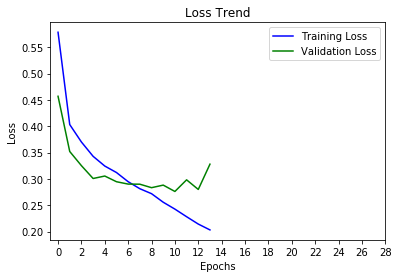

In [104]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,brepoha)[0::2])
plt.legend()
plt.show()

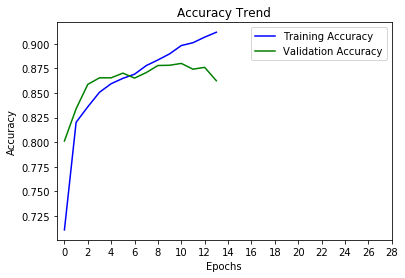

In [105]:
accuracy = history.accuracy
val_accuracy = history.val_accuracy

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Trend')
plt.plot(accuracy, 'blue', label='Training Accuracy')
plt.plot(val_accuracy, 'green', label='Validation Accuracy')
plt.xticks(range(0,brepoha)[0::2])
plt.legend()
plt.show()

I am 99.67% sure this is a Male


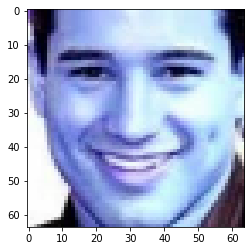

I am 99.83% sure this is a Male


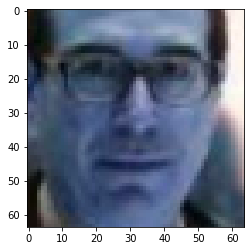

I am 98.75% sure this is a Female


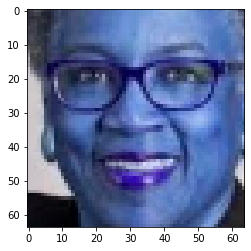

I am 50.91% sure this is a Female


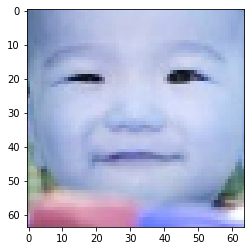

I am 100.00% sure this is a Male


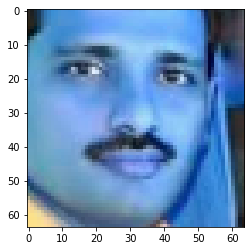

I am 100.00% sure this is a Female


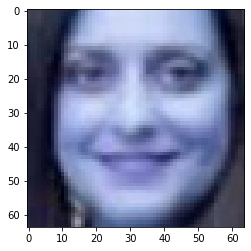

I am 66.15% sure this is a Female


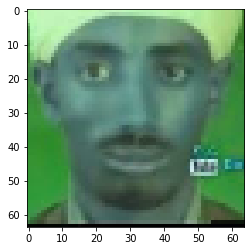

I am 99.44% sure this is a Female


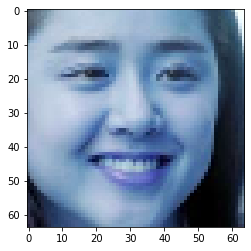

I am 99.92% sure this is a Female


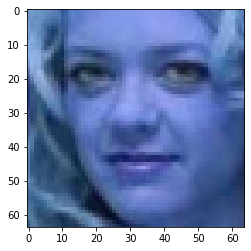

I am 100.00% sure this is a Male


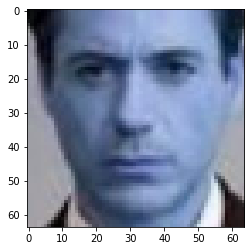

I am 99.63% sure this is a Male


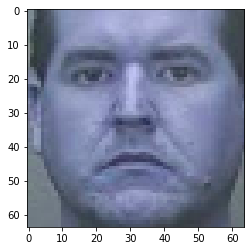

I am 100.00% sure this is a Male


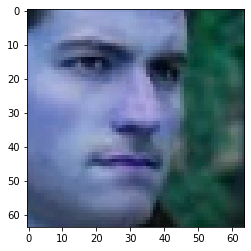

I am 99.03% sure this is a Female


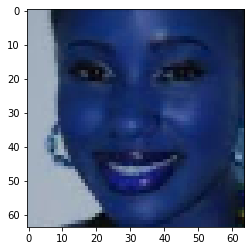

I am 86.50% sure this is a Male


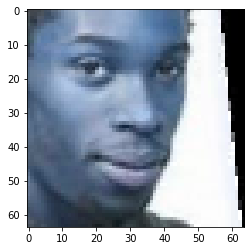

I am 99.99% sure this is a Female


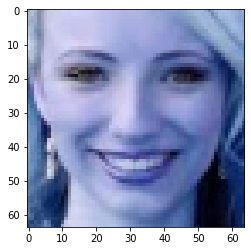

I am 99.99% sure this is a Female


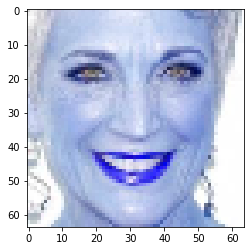

I am 65.01% sure this is a Female


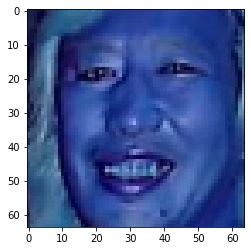

I am 99.98% sure this is a Male


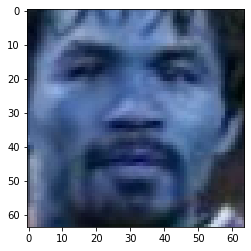

I am 91.60% sure this is a Female


KeyboardInterrupt: ignored

In [97]:
ypredikcije=np.ndarray(len(predikcije),dtype=np.uint8)
for i in range(0,len(verifikacija)):
    if predikcije[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Female'.format(predikcije[i][0]))

    else: 
        print('I am {:.2%} sure this is a Male'.format(1-predikcije[i][0]))
        
    plt.imshow(verifikacija[i].T)
    plt.show()

In [49]:
import collections
type(predikcije)


print((yver==0).sum())
print((yver==1).sum())
print((trenytren==0).sum())
print((trenytren==1).sum())
print((predikcije<0.5).sum())
print((predikcije>=0.5).sum())

pred=np.ndarray(len(predikcije),dtype=np.uint8)
for i in range(0, len(predikcije)):
  if (predikcije[i]<=0.5):
    pred[i]=0
  else:
    pred[i]=1





2483
2206
7774
7226
2247
2442


In [51]:
import sklearn
print(sklearn.metrics.confusion_matrix(yver, pred))
acc=(1629+2041)/(1629+822+197+2041)
acc1=(2203+1450)/(2203+248+788+1450)
acc2=(2174+1889)/(2147+277+349+1889)
acc3=(2086+2045)/(2086+2045+397+161)
print(acc*100)
print(acc1*100)
print(acc2*100)
print(acc3*100)

[[2086  397]
 [ 161 2045]]
78.2682874813393
77.90573683088078
87.15143715143715
88.09980806142035
